# 2. 1-Layer LSTM

- 저장한 수익률 데이터 불러오기
- 모델 생성 및 가중치 초기화
- 모델 학습
- 모델 평가
- 예측 진행 및 결과 확인

## Overall Process
![](/home/jhbale11/TimeSeriesForecasting_WithPytorch/img/Process.png)

## Load Library

In [25]:
import torch
import torch.nn as nn
from torch.autograd import Variable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler
import os
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta 
from typing import Union
from tqdm.notebook import tqdm_notebook as tqdm
from fastprogress import master_bar, progress_bar
from itertools import cycle
import datetime as dt

# matplotlib 설정
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

In [13]:
# 코드 재생산을 위해 SEED를 고정하겠습니다.
SEED = 1345

os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [14]:
y = pd.read_csv('./data/samsung_df.csv')
date_index = y['Date']
dates = date_index[0:1248]
dates_list = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in dates]
y.index = pd.to_datetime(y.Date)
y = y.drop(['Date'], axis=1)
y

,Close
Date,
2018-01-03,0.011760
2018-01-04,-0.010461
2018-01-05,0.020360
2018-01-08,-0.001919
2018-01-09,-0.031142
...,...
2023-01-25,0.024272
2023-01-26,0.007899
2023-01-27,0.012539


## Normalize the Data

In [15]:
data = np.array(y)
scaler = MinMaxScaler(feature_range=(-1,1))
train_data_normalized = scaler.fit_transform(data.reshape(-1,1))
train_data_normalized

array([[-0.10267399],
       [-0.36629746],
       [-0.00064533],
       ...,
       [-0.09343115],
       [-0.48093303],
       [-0.59828752]])

In [16]:
# 이 함수는 28일로 이루어져 있는 sequences와 하루의 label을 생성합니다.
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [17]:
seq_length = 21
x, y = sliding_windows(train_data_normalized, seq_length)
print(x.shape)
print(y.shape)

(1227, 21, 1)
(1227, 1)


In [18]:
train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

print("train shape is:",trainX.size())
print("train label shape is:",trainY.size())
print("test shape is:",testX.size())
print("test label shape is:",testY.size())

train shape is: torch.Size([981, 21, 1])
train label shape is: torch.Size([981, 1])
test shape is: torch.Size([246, 21, 1])
test label shape is: torch.Size([246, 1])


## 1-Layer LSTM
![](/home/jhbale11/TimeSeriesForecasting_WithPytorch/img/LSTM_1.png)

- `num_classes` : 
- `num_layer` : LSTM 층을 얼마나 쌓을지 결정하는 변수입니다.
- `input_size` : input의 feature dimension을 넣어야 합니다. `time_step`을 넣어주는 것이 아니라 input feature dimension을 넣어주어야 합니다. 우리의 경우 21개의 샘플로 이루어진 하나의 input을 넣어주는 것이기 때문에 `1`으로 하겠습니다.
- `hidden_size` : 내부에서 어떤 Feature Dimension으로 바꿔주고 싶은지에 대한 변수입니다. 

In [19]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        #self.seq_length = seq_length
        self.dropout = nn.Dropout(p=0.2)
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True,dropout = 0.25)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        out = self.dropout(out)
       
        return out

In [20]:
# Parameters
num_epochs = 30000
learning_rate = 1e-3
input_size = 1
hidden_size = 126
num_layers = 1
num_classes = 1
device = torch.device('cuda')

In [21]:
#####Init the Model #######################
lstm = LSTM(num_classes, input_size, hidden_size, num_layers).to(device)

##### Set Criterion Optimzer and scheduler ####################
criterion = torch.nn.MSELoss().to(device)    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=500,factor =0.5 ,min_lr=1e-7, eps=1e-08)

In [22]:
# Train the model
for epoch in progress_bar(range(num_epochs)): 
    lstm.train()
    outputs = lstm(trainX.to(device))
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY.to(device))
    
    loss.backward()
    
    optimizer.step()
    
    #Evaluate on test     
    lstm.eval()
    valid = lstm(testX.to(device))
    vall_loss = criterion(valid, testY.to(device))
    scheduler.step(vall_loss)
    
    if epoch % 1000 == 0:
      print("Epoch: %d, loss: %1.5f valid loss:  %1.5f " %(epoch, loss.cpu().item(),vall_loss.cpu().item()))

Epoch: 0, loss: 0.07669 valid loss:  0.06443 
Epoch: 1000, loss: 0.04991 valid loss:  0.03565 
Epoch: 2000, loss: 0.04893 valid loss:  0.03628 
Epoch: 3000, loss: 0.04555 valid loss:  0.03682 
Epoch: 4000, loss: 0.04958 valid loss:  0.03672 
Epoch: 5000, loss: 0.04871 valid loss:  0.03672 
Epoch: 6000, loss: 0.04831 valid loss:  0.03679 
Epoch: 7000, loss: 0.04523 valid loss:  0.03679 
Epoch: 8000, loss: 0.04788 valid loss:  0.03677 
Epoch: 9000, loss: 0.04670 valid loss:  0.03677 
Epoch: 10000, loss: 0.04883 valid loss:  0.03677 
Epoch: 11000, loss: 0.04789 valid loss:  0.03678 
Epoch: 12000, loss: 0.04531 valid loss:  0.03677 
Epoch: 13000, loss: 0.04984 valid loss:  0.03676 
Epoch: 14000, loss: 0.04648 valid loss:  0.03678 
Epoch: 15000, loss: 0.04810 valid loss:  0.03678 
Epoch: 16000, loss: 0.04955 valid loss:  0.03679 
Epoch: 17000, loss: 0.04832 valid loss:  0.03678 
Epoch: 18000, loss: 0.04741 valid loss:  0.03678 
Epoch: 19000, loss: 0.04757 valid loss:  0.03678 
Epoch: 20000,

In [23]:
######Prediction###############
lstm.eval()
train_predict = lstm(dataX.to(device))
data_predict = train_predict.cpu().data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = scaler.inverse_transform(data_predict)
dataY_plot = scaler.inverse_transform(dataY_plot)

## Add dates
df_predict = pd.DataFrame(data_predict)
df_predict = df_predict.set_index([dates_list[:-21]])
df_labels = pd.DataFrame(dataY_plot)
df_labels = df_labels.set_index([dates_list[:-21]])

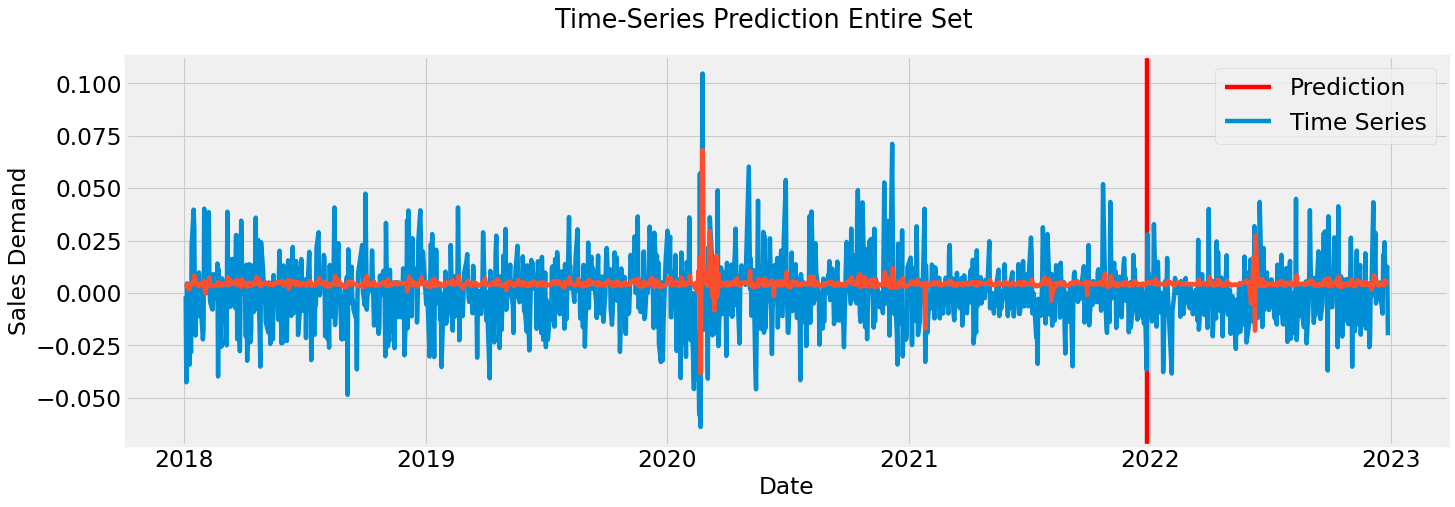

In [26]:
# Plot 
figure(num=None, figsize=(19, 6), dpi=80, facecolor='w', edgecolor='k')
plt.axvline(x=dates_list[train_size], c='r')
plt.plot( df_labels[0])
plt.plot(df_predict[0])
plt.legend(['Prediction','Time Series'],fontsize = 21)
plt.suptitle('Time-Series Prediction Entire Set',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()

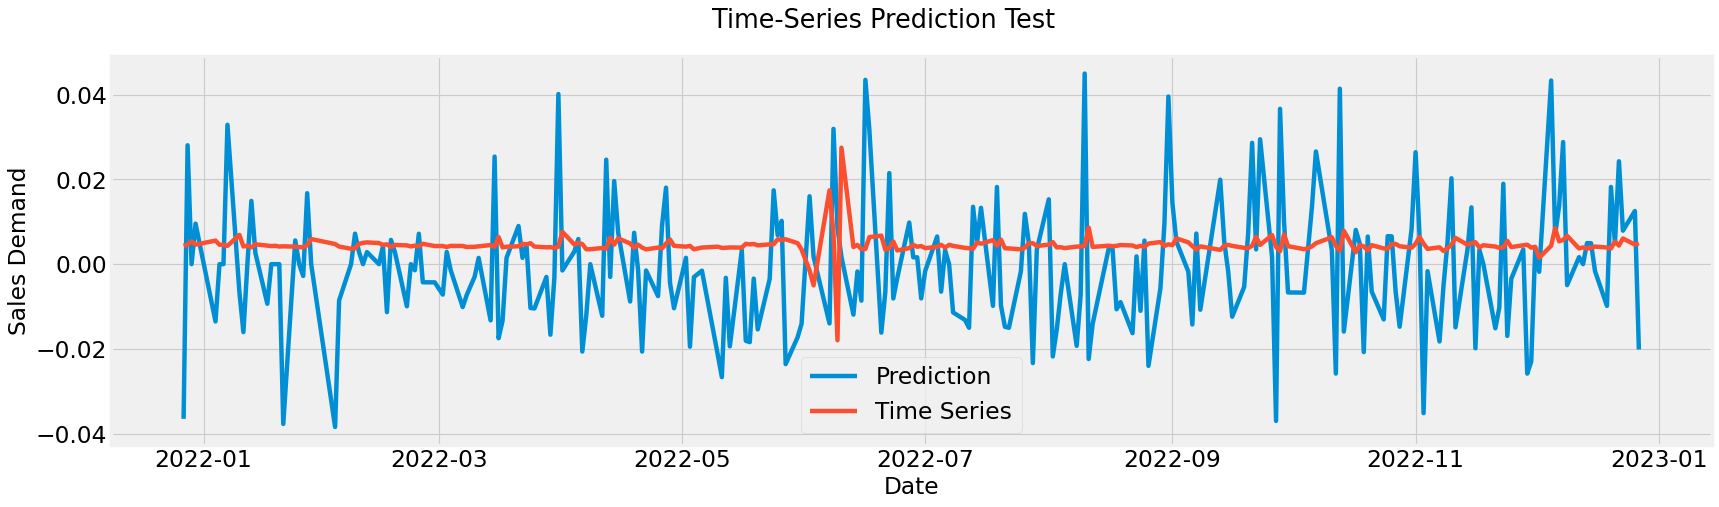

In [27]:
#######Plot the test set ##########################
figure(num=None, figsize=(23, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df_labels.iloc[-testX.size()[0]:][0])
plt.plot(df_predict.iloc[-testX.size()[0]:][0])
plt.legend(['Prediction','Time Series'],fontsize = 21)
plt.suptitle('Time-Series Prediction Test',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()

In [28]:
####### Calculate RMSE ##################
np.sqrt(((dataY_plot[-testX.size()[0]:] - data_predict[-testX.size()[0]:] ) ** 2).mean())

0.016164126